In [28]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
from torch.optim import lr_scheduler
import argparse
import time
from torchsummary import summary

In [29]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [30]:
cd /content/drive/MyDrive/ProjectB

/content/drive/MyDrive/ProjectB


In [31]:
from networks import MLP, ConvNet, LeNet, AlexNet, AlexNetBN, VGG11, VGG11BN, ResNet18, ResNet18BN_AP, ResNet18BN
from utils import get_loops, get_dataset, get_network, get_eval_pool, evaluate_synset, get_daparam, match_loss, get_time, TensorDataset, epoch, DiffAugment, ParamDiffAug

# Dataset Preparation (MNIST)

In [ ]:
mean = [0.1307]
std = [0.3081]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean, std=std)])

In [ ]:
data_train = datasets.MNIST(root = "./data/",
               transform=transform,
               train = True,
               download = True)

data_test = datasets.MNIST(root="./data/",
               transform = transform,
               train = False)

In [ ]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                         batch_size = 256,
                         shuffle = True,
                         num_workers=2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                         batch_size = 256,
                         shuffle = True,
                         num_workers=2)

In [ ]:
print(len(data_train))

60000


[8, 1, 2, 5, 1, 7, 4, 2, 4, 7, 1, 8, 4, 3, 8, 8, 7, 0, 2, 9, 3, 3, 3, 7, 3, 2, 1, 2, 8, 8, 3, 2, 2, 6, 1, 7, 8, 0, 8, 3, 3, 7, 0, 5, 4, 1, 1, 0, 6, 5, 2, 6, 7, 8, 2, 9, 5, 7, 4, 3, 7, 5, 2, 0, 6, 3, 2, 2, 9, 2, 8, 5, 8, 5, 6, 7, 1, 4, 8, 6, 2, 4, 8, 1, 9, 4, 9, 1, 1, 4, 0, 0, 4, 1, 6, 3, 9, 9, 8, 6, 2, 8, 0, 3, 6, 5, 8, 0, 8, 6, 1, 0, 1, 6, 9, 0, 2, 0, 3, 4, 2, 1, 7, 2, 9, 5, 1, 9, 8, 2, 2, 0, 5, 8, 6, 0, 2, 9, 3, 8, 0, 3, 0, 9, 3, 0, 7, 2, 4, 9, 3, 2, 3, 3, 1, 2, 2, 5, 5, 7, 5, 7, 1, 6, 9, 7, 5, 3, 6, 6, 4, 5, 0, 7, 3, 7, 9, 6, 1, 1, 6, 4, 8, 8, 0, 5, 2, 1, 8, 2, 4, 7, 2, 8, 6, 9, 6, 1, 4, 9, 3, 4, 5, 6, 6, 8, 6, 8, 8, 1, 3, 9, 7, 8, 6, 7, 4, 6, 8, 9, 8, 2, 2, 6, 4, 7, 6, 6, 1, 6, 5, 8, 3, 4, 9, 6, 1, 3, 1, 2, 0, 0, 8, 5, 4, 9, 0, 2, 1, 6, 9, 2, 5, 0, 9, 0]


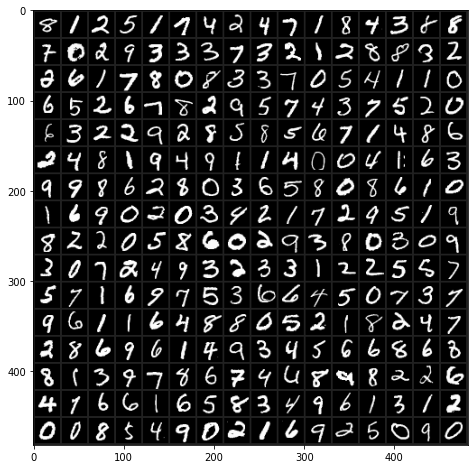

In [ ]:
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images, nrow=16)

img = img.numpy().transpose(1,2,0)
img = img*std+mean
print([int(labels[i]) for i in range(256)])
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.imshow(img)

# Load Network (ConvNet)

In [43]:
net = get_network('ConvNet', 1 , num_classes = 10, im_size=(32, 32))
net = net.to('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
criterion = nn.CrossEntropyLoss()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.9)  # optimizer_img for synthetic data
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_net,40)
num_epochs = 20

In [46]:
summary(net,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 36, 36]           1,280
         GroupNorm-2          [-1, 128, 36, 36]             256
              ReLU-3          [-1, 128, 36, 36]               0
         AvgPool2d-4          [-1, 128, 18, 18]               0
            Conv2d-5          [-1, 128, 18, 18]         147,584
         GroupNorm-6          [-1, 128, 18, 18]             256
              ReLU-7          [-1, 128, 18, 18]               0
         AvgPool2d-8            [-1, 128, 9, 9]               0
            Conv2d-9            [-1, 128, 9, 9]         147,584
        GroupNorm-10            [-1, 128, 9, 9]             256
             ReLU-11            [-1, 128, 9, 9]               0
        AvgPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                   [-1, 10]          20,490
Total params: 317,706
Trainable params:

In [ ]:
t_all = 0
for epoch in range(num_epochs):
  net.train(True) # Train mode 
  loss_tot = 0.0
  correct_tot = 0
  print("Epoch {}/{}".format(epoch, num_epochs))
  print("-"*10)
  t0 = time.time()
  for data in data_loader_train:
    imgs, labels = data
    imgs = imgs.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer_net.zero_grad() # clear the grad
    outputs = net(imgs) # forward
    loss = criterion(outputs,labels) # loss calculation
    pred = torch.argmax(outputs,dim=1)
    loss_tot += loss.data
    correct_tot += torch.sum(pred == labels.data)
    loss.backward()
    optimizer_net.step()
  scheduler.step()
  t1 = time.time()
    
  net.train(False)
  testing_correct = 0
  for data in data_loader_test:
    img_test, label_test = data
    img_test = img_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    label_test = label_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = net(img_test)
    pred = torch.argmax(outputs,dim=1)
    testing_correct += torch.sum(pred == label_test.data)
  print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(loss_tot/len(data_train),
                                           100*correct_tot/len(data_train),
                                           100*testing_correct/len(data_test)))
  print("Training time:{:.4f}s".format(t1-t0))
  t_all = t_all+(t1-t0)
print(t_all)

Epoch 0/20
----------
Loss is:0.0000, Train Accuracy is:99.9650%, Test Accuracy is:99.4600
Training time:9.5109s
Epoch 1/20
----------
Loss is:0.0000, Train Accuracy is:99.9667%, Test Accuracy is:99.4600
Training time:9.7386s
Epoch 2/20
----------
Loss is:0.0000, Train Accuracy is:99.9700%, Test Accuracy is:99.4000
Training time:9.3257s
Epoch 3/20
----------
Loss is:0.0000, Train Accuracy is:99.9800%, Test Accuracy is:99.4700
Training time:9.3932s
Epoch 4/20
----------
Loss is:0.0000, Train Accuracy is:99.9750%, Test Accuracy is:99.4600
Training time:9.4296s
Epoch 5/20
----------
Loss is:0.0000, Train Accuracy is:99.9733%, Test Accuracy is:99.4700
Training time:11.7045s
Epoch 6/20
----------
Loss is:0.0000, Train Accuracy is:99.9767%, Test Accuracy is:99.4400
Training time:9.6616s
Epoch 7/20
----------
Loss is:0.0000, Train Accuracy is:99.9817%, Test Accuracy is:99.4500
Training time:9.5422s
Epoch 8/20
----------
Loss is:0.0000, Train Accuracy is:99.9850%, Test Accuracy is:99.4800
Trai

# Data Preparation (CIFAR10)

In [32]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean, std=std)])
transform1 = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomGrayscale(), transforms.ToTensor(),transforms.Normalize(mean=mean, std=std)])

In [33]:
data_train = datasets.CIFAR10(root = "./data/",
               transform=transform1,
               train = True,
               download = True)

data_test = datasets.CIFAR10(root="./data/",
               transform = transform,
               train = False)

Files already downloaded and verified


In [34]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                         batch_size = 256,
                         shuffle = True,
                         num_workers=2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                         batch_size = 256,
                         shuffle = True,
                         num_workers=2)

[3, 8, 4, 7, 4, 3, 6, 7, 6, 9, 8, 1, 9, 2, 7, 6, 9, 6, 2, 5, 8, 2, 5, 6, 3, 9, 6, 7, 4, 0, 9, 9, 2, 3, 5, 7, 9, 3, 4, 4, 4, 0, 4, 9, 7, 3, 0, 7, 2, 1, 2, 9, 8, 9, 6, 2, 9, 9, 0, 2, 5, 7, 4, 4, 1, 8, 4, 4, 6, 4, 8, 0, 2, 7, 5, 7, 4, 3, 4, 2, 7, 2, 5, 6, 4, 5, 6, 9, 9, 8, 3, 8, 4, 5, 9, 9, 1, 8, 3, 4, 0, 8, 0, 9, 6, 0, 2, 9, 3, 2, 9, 0, 3, 3, 7, 4, 6, 2, 1, 1, 8, 7, 4, 3, 0, 0, 9, 7, 6, 6, 5, 8, 9, 8, 7, 8, 5, 0, 3, 0, 9, 8, 7, 9, 0, 6, 7, 2, 0, 0, 9, 3, 3, 1, 3, 0, 9, 9, 6, 3, 7, 0, 7, 1, 5, 0, 9, 7, 7, 1, 9, 2, 5, 0, 3, 3, 5, 0, 0, 1, 2, 8, 0, 7, 2, 1, 8, 7, 1, 4, 3, 0, 2, 3, 8, 6, 7, 0, 5, 9, 2, 9, 5, 7, 6, 2, 9, 5, 4, 8, 8, 1, 5, 0, 3, 0, 1, 6, 8, 5, 5, 8, 0, 6, 1, 1, 6, 6, 6, 5, 0, 5, 6, 2, 1, 2, 4, 4, 0, 7, 6, 2, 9, 3, 7, 7, 5, 8, 0, 7, 3, 7, 6, 7, 4, 2]


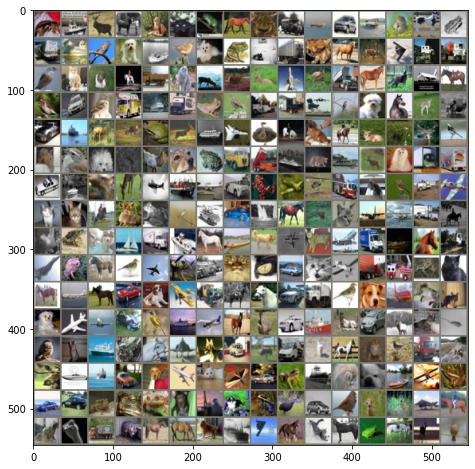

In [ ]:
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images, nrow=16)

img = img.numpy().transpose(1,2,0)
img = img*std+mean
print([int(labels[i]) for i in range(256)])
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.imshow(img)

# Load Network (ConvNet)

In [35]:
net = get_network('ConvNet', 3 , num_classes = 10, im_size=(32, 32))
net = net.to('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
criterion = nn.CrossEntropyLoss()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.95)  # optimizer_img for synthetic data
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_net,20)
num_epochs = 20

In [42]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
         GroupNorm-2          [-1, 128, 32, 32]             256
              ReLU-3          [-1, 128, 32, 32]               0
         AvgPool2d-4          [-1, 128, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]         147,584
         GroupNorm-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         AvgPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]         147,584
        GroupNorm-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        AvgPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                   [-1, 10]          20,490
Total params: 320,010
Trainable params:

In [ ]:
t_all = 0
for epoch in range(num_epochs):
  net.train(True) # Train mode 
  loss_tot = 0.0
  correct_tot = 0
  print("Epoch {}/{}".format(epoch, num_epochs))
  print("-"*10)
  t0=time.time()
  for data in data_loader_train:
    imgs, labels = data
    imgs = imgs.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer_net.zero_grad() # clear the grad
    outputs = net(imgs) # forward
    loss = criterion(outputs,labels) # loss calculation
    pred = torch.argmax(outputs,dim=1)
    loss_tot += loss.data
    correct_tot += torch.sum(pred == labels.data)
    loss.backward()
    optimizer_net.step()
  scheduler.step()
  t1=time.time()
    
  net.train(False)
  testing_correct = 0
  for data in data_loader_test:
    img_test, label_test = data
    img_test = img_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    label_test = label_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = net(img_test)
    pred = torch.argmax(outputs,dim=1)
    testing_correct += torch.sum(pred == label_test.data)
  print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(loss_tot/len(data_train),
                                           100*correct_tot/len(data_train),
                                           100*testing_correct/len(data_test)))
  print("Training time:{:.4f}s".format(t1-t0))
  t_all = t_all+(t1-t0)
print(t_all)


Epoch 0/20
----------
Loss is:0.0027, Train Accuracy is:76.0080%, Test Accuracy is:74.1000
Training time:13.0984s
Epoch 1/20
----------
Loss is:0.0025, Train Accuracy is:77.6140%, Test Accuracy is:75.9400
Training time:13.3041s
Epoch 2/20
----------
Loss is:0.0023, Train Accuracy is:79.6480%, Test Accuracy is:77.8400
Training time:12.9662s
Epoch 3/20
----------
Loss is:0.0022, Train Accuracy is:80.6800%, Test Accuracy is:78.2800
Training time:13.0791s
Epoch 4/20
----------
Loss is:0.0021, Train Accuracy is:82.1860%, Test Accuracy is:78.4100
Training time:12.9487s
Epoch 5/20
----------
Loss is:0.0019, Train Accuracy is:83.6180%, Test Accuracy is:79.3800
Training time:13.3535s
Epoch 6/20
----------
Loss is:0.0018, Train Accuracy is:84.5620%, Test Accuracy is:80.3800
Training time:13.1524s
Epoch 7/20
----------
Loss is:0.0017, Train Accuracy is:85.4960%, Test Accuracy is:80.0900
Training time:13.0786s
Epoch 8/20
----------
Loss is:0.0016, Train Accuracy is:86.6460%, Test Accuracy is:80.58